# Test different parameters systematically for sigma clipping in appaloosa

First, execute the following cell for different parameters, then store the results in folders accordingly, add the record to the spreadsheet. Before, execute cell below to load necessary modules.

In [2]:
for oid in oid_list:
    RunLC_test(oid)

/home/ekaterina/Documents/appaloosa/appaloosa/appaloosa.py:271: FutureWarning: pd.rolling_std is deprecated for ndarrays and will be removed in a future version
  error = np.ones_like(time[isrl]) * np.nanmedian(rolling_std(flux_raw[isrl], win_size, center=True))
/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:112: FutureWarning: pd.rolling_median is deprecated for ndarrays and will be removed in a future version
  flux_sm = rolling_median(np.array(flux[x], dtype='float'), krnl)
/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:74: FutureWarning: pd.rolling_median is deprecated for ndarrays and will be removed in a future version
  flux_sm = rolling_median(flux[dl[i]:dr[i]], krnl)
/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:359: FutureWarning: pd.rolling_median is deprecated for ndarrays and will be removed in a future version
  flux_i_sm = rolling_median(flux_i, nptsmooth, center=True)
/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:359: FutureWarn

228682441	2018-03-01 11:43:15.856751	9	stars_shortlist/M67/hlsp_everest_k2_llc_228682441-c05_kepler_v2.0_lc.fits	5	68.1263888889	29.424381432364804	2306.61103845



/home/ekaterina/Documents/appaloosa/appaloosa/appaloosa.py:271: FutureWarning: pd.rolling_std is deprecated for ndarrays and will be removed in a future version
  error = np.ones_like(time[isrl]) * np.nanmedian(rolling_std(flux_raw[isrl], win_size, center=True))
/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:112: FutureWarning: pd.rolling_median is deprecated for ndarrays and will be removed in a future version
  flux_sm = rolling_median(np.array(flux[x], dtype='float'), krnl)
/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:74: FutureWarning: pd.rolling_median is deprecated for ndarrays and will be removed in a future version
  flux_sm = rolling_median(flux[dl[i]:dr[i]], krnl)
/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:359: FutureWarning: pd.rolling_median is deprecated for ndarrays and will be removed in a future version
  flux_i_sm = rolling_median(flux_i, nptsmooth, center=True)
/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:359: FutureWarn

211410963	2018-03-01 11:43:16.391841	20	stars_shortlist/M67/hlsp_everest_k2_llc_211410963-c05_kepler_v2.0_lc.fits	5	68.1263888889	29.424381432364804	2306.61102064



/home/ekaterina/Documents/appaloosa/appaloosa/aflare.py:88: RuntimeWarning: divide by zero encountered in true_divide
  flare = np.piecewise(t, [(t<= tpeak) * (t-tpeak)/fwhm > -1.,
/home/ekaterina/Documents/appaloosa/appaloosa/aflare.py:88: RuntimeWarning: invalid value encountered in true_divide
  flare = np.piecewise(t, [(t<= tpeak) * (t-tpeak)/fwhm > -1.,
/home/ekaterina/Documents/appaloosa/appaloosa/aflare.py:88: RuntimeWarning: invalid value encountered in greater
  flare = np.piecewise(t, [(t<= tpeak) * (t-tpeak)/fwhm > -1.,
/home/ekaterina/Documents/appaloosa/appaloosa/appaloosa.py:271: FutureWarning: pd.rolling_std is deprecated for ndarrays and will be removed in a future version
  error = np.ones_like(time[isrl]) * np.nanmedian(rolling_std(flux_raw[isrl], win_size, center=True))
/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:112: FutureWarning: pd.rolling_median is deprecated for ndarrays and will be removed in a future version
  flux_sm = rolling_median(np.array(fl

211411112	2018-03-01 11:43:17.022388	19	stars_shortlist/M67/hlsp_everest_k2_llc_211411112-c05_kepler_v2.0_lc.fits	5	68.1263888889	29.424381432364804	2306.61102002



/home/ekaterina/Documents/appaloosa/appaloosa/aflare.py:95: RuntimeWarning: divide by zero encountered in true_divide
  lambda x: (_fd[0]*np.exp( ((x-tpeak)/fwhm)*_fd[1] ) +
/home/ekaterina/Documents/appaloosa/appaloosa/aflare.py:96: RuntimeWarning: divide by zero encountered in true_divide
  _fd[2]*np.exp( ((x-tpeak)/fwhm)*_fd[3] ))]
/home/ekaterina/Documents/appaloosa/appaloosa/appaloosa.py:271: FutureWarning: pd.rolling_std is deprecated for ndarrays and will be removed in a future version
  error = np.ones_like(time[isrl]) * np.nanmedian(rolling_std(flux_raw[isrl], win_size, center=True))
/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:112: FutureWarning: pd.rolling_median is deprecated for ndarrays and will be removed in a future version
  flux_sm = rolling_median(np.array(flux[x], dtype='float'), krnl)
/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:74: FutureWarning: pd.rolling_median is deprecated for ndarrays and will be removed in a future version
  flux_sm 

211416648	2018-03-01 11:43:17.660201	21	stars_shortlist/M67/hlsp_everest_k2_llc_211416648-c05_kepler_v2.0_lc.fits	5	68.1263888889	29.424381432364804	2306.61101947



/home/ekaterina/Documents/appaloosa/appaloosa/appaloosa.py:271: FutureWarning: pd.rolling_std is deprecated for ndarrays and will be removed in a future version
  error = np.ones_like(time[isrl]) * np.nanmedian(rolling_std(flux_raw[isrl], win_size, center=True))
/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:112: FutureWarning: pd.rolling_median is deprecated for ndarrays and will be removed in a future version
  flux_sm = rolling_median(np.array(flux[x], dtype='float'), krnl)
/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:74: FutureWarning: pd.rolling_median is deprecated for ndarrays and will be removed in a future version
  flux_sm = rolling_median(flux[dl[i]:dr[i]], krnl)
/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:359: FutureWarning: pd.rolling_median is deprecated for ndarrays and will be removed in a future version
  flux_i_sm = rolling_median(flux_i, nptsmooth, center=True)
/usr/local/lib/python3.5/dist-packages/scipy/optimize/minpack.py:779: Op

211396422	2018-03-01 11:43:18.639085	8	stars_shortlist/M67/hlsp_everest_k2_llc_211396422-c05_kepler_v2.0_lc.fits	5	68.1263888889	29.424381432364804	2306.6110411



/home/ekaterina/Documents/appaloosa/appaloosa/aflare.py:88: RuntimeWarning: divide by zero encountered in true_divide
  flare = np.piecewise(t, [(t<= tpeak) * (t-tpeak)/fwhm > -1.,
/home/ekaterina/Documents/appaloosa/appaloosa/aflare.py:88: RuntimeWarning: invalid value encountered in true_divide
  flare = np.piecewise(t, [(t<= tpeak) * (t-tpeak)/fwhm > -1.,
/home/ekaterina/Documents/appaloosa/appaloosa/aflare.py:88: RuntimeWarning: invalid value encountered in greater
  flare = np.piecewise(t, [(t<= tpeak) * (t-tpeak)/fwhm > -1.,
/home/ekaterina/Documents/appaloosa/appaloosa/aflare.py:95: RuntimeWarning: divide by zero encountered in true_divide
  lambda x: (_fd[0]*np.exp( ((x-tpeak)/fwhm)*_fd[1] ) +
/home/ekaterina/Documents/appaloosa/appaloosa/aflare.py:96: RuntimeWarning: divide by zero encountered in true_divide
  _fd[2]*np.exp( ((x-tpeak)/fwhm)*_fd[3] ))]
/usr/local/lib/python3.5/dist-packages/scipy/optimize/minpack.py:779: OptimizeWarning: Covariance of the parameters could not 

211412571	2018-03-01 11:43:19.163584	54	stars_shortlist/M67/hlsp_everest_k2_llc_211412571-c05_kepler_v2.0_lc.fits	5	68.1263888889	29.424381432364804	2306.61101854



/home/ekaterina/Documents/appaloosa/appaloosa/aflare.py:95: RuntimeWarning: divide by zero encountered in true_divide
  lambda x: (_fd[0]*np.exp( ((x-tpeak)/fwhm)*_fd[1] ) +
/home/ekaterina/Documents/appaloosa/appaloosa/aflare.py:96: RuntimeWarning: divide by zero encountered in true_divide
  _fd[2]*np.exp( ((x-tpeak)/fwhm)*_fd[3] ))]
/home/ekaterina/Documents/appaloosa/appaloosa/aflare.py:95: RuntimeWarning: overflow encountered in exp
  lambda x: (_fd[0]*np.exp( ((x-tpeak)/fwhm)*_fd[1] ) +
/home/ekaterina/Documents/appaloosa/appaloosa/appaloosa.py:271: FutureWarning: pd.rolling_std is deprecated for ndarrays and will be removed in a future version
  error = np.ones_like(time[isrl]) * np.nanmedian(rolling_std(flux_raw[isrl], win_size, center=True))
/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:112: FutureWarning: pd.rolling_median is deprecated for ndarrays and will be removed in a future version
  flux_sm = rolling_median(np.array(flux[x], dtype='float'), krnl)
/home/ekate

211418561	2018-03-01 11:43:19.841454	15	stars_shortlist/M67/hlsp_everest_k2_llc_211418561-c05_kepler_v2.0_lc.fits	5	68.1263888889	29.424381432364804	2306.61101919



/usr/local/lib/python3.5/dist-packages/scipy/optimize/minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/ekaterina/Documents/appaloosa/appaloosa/appaloosa.py:271: FutureWarning: pd.rolling_std is deprecated for ndarrays and will be removed in a future version
  error = np.ones_like(time[isrl]) * np.nanmedian(rolling_std(flux_raw[isrl], win_size, center=True))
/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:112: FutureWarning: pd.rolling_median is deprecated for ndarrays and will be removed in a future version
  flux_sm = rolling_median(np.array(flux[x], dtype='float'), krnl)
/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:74: FutureWarning: pd.rolling_median is deprecated for ndarrays and will be removed in a future version
  flux_sm = rolling_median(flux[dl[i]:dr[i]], krnl)
/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:359: FutureWarning: pd.rolling_median is deprecated for ndarrays and wi

211418176	2018-03-01 11:43:20.495470	16	stars_shortlist/M67/hlsp_everest_k2_llc_211418176-c05_kepler_v2.0_lc.fits	5	68.1263888889	29.424381432364804	2306.611019



/home/ekaterina/Documents/appaloosa/appaloosa/appaloosa.py:271: FutureWarning: pd.rolling_std is deprecated for ndarrays and will be removed in a future version
  error = np.ones_like(time[isrl]) * np.nanmedian(rolling_std(flux_raw[isrl], win_size, center=True))
/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:112: FutureWarning: pd.rolling_median is deprecated for ndarrays and will be removed in a future version
  flux_sm = rolling_median(np.array(flux[x], dtype='float'), krnl)
/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:74: FutureWarning: pd.rolling_median is deprecated for ndarrays and will be removed in a future version
  flux_sm = rolling_median(flux[dl[i]:dr[i]], krnl)
/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:359: FutureWarning: pd.rolling_median is deprecated for ndarrays and will be removed in a future version
  flux_i_sm = rolling_median(flux_i, nptsmooth, center=True)
/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:359: FutureWarn

211403974	2018-03-01 11:43:21.171992	9	stars_shortlist/M67/hlsp_everest_k2_llc_211403974-c05_kepler_v2.0_lc.fits	5	68.1263888889	29.424381432364804	2306.61102172



/home/ekaterina/Documents/appaloosa/appaloosa/aflare.py:88: RuntimeWarning: divide by zero encountered in true_divide
  flare = np.piecewise(t, [(t<= tpeak) * (t-tpeak)/fwhm > -1.,
/home/ekaterina/Documents/appaloosa/appaloosa/aflare.py:88: RuntimeWarning: invalid value encountered in true_divide
  flare = np.piecewise(t, [(t<= tpeak) * (t-tpeak)/fwhm > -1.,
/home/ekaterina/Documents/appaloosa/appaloosa/aflare.py:88: RuntimeWarning: invalid value encountered in greater
  flare = np.piecewise(t, [(t<= tpeak) * (t-tpeak)/fwhm > -1.,
/home/ekaterina/Documents/appaloosa/appaloosa/aflare.py:95: RuntimeWarning: divide by zero encountered in true_divide
  lambda x: (_fd[0]*np.exp( ((x-tpeak)/fwhm)*_fd[1] ) +
/home/ekaterina/Documents/appaloosa/appaloosa/aflare.py:96: RuntimeWarning: divide by zero encountered in true_divide
  _fd[2]*np.exp( ((x-tpeak)/fwhm)*_fd[3] ))]
/usr/local/lib/python3.5/dist-packages/scipy/optimize/minpack.py:779: OptimizeWarning: Covariance of the parameters could not 

211417817	2018-03-01 11:43:21.846089	17	stars_shortlist/M67/hlsp_everest_k2_llc_211417817-c05_kepler_v2.0_lc.fits	5	68.1263888889	29.424381432364804	2306.61101863



/home/ekaterina/Documents/appaloosa/appaloosa/appaloosa.py:271: FutureWarning: pd.rolling_std is deprecated for ndarrays and will be removed in a future version
  error = np.ones_like(time[isrl]) * np.nanmedian(rolling_std(flux_raw[isrl], win_size, center=True))
/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:112: FutureWarning: pd.rolling_median is deprecated for ndarrays and will be removed in a future version
  flux_sm = rolling_median(np.array(flux[x], dtype='float'), krnl)
/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:74: FutureWarning: pd.rolling_median is deprecated for ndarrays and will be removed in a future version
  flux_sm = rolling_median(flux[dl[i]:dr[i]], krnl)
/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:359: FutureWarning: pd.rolling_median is deprecated for ndarrays and will be removed in a future version
  flux_i_sm = rolling_median(flux_i, nptsmooth, center=True)
/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:359: FutureWarn

211413212	2018-03-01 11:43:22.485489	65	stars_shortlist/M67/hlsp_everest_k2_llc_211413212-c05_kepler_v2.0_lc.fits	5	68.1263888889	29.424381432364804	2306.61101805



/home/ekaterina/Documents/appaloosa/appaloosa/aflare.py:95: RuntimeWarning: divide by zero encountered in true_divide
  lambda x: (_fd[0]*np.exp( ((x-tpeak)/fwhm)*_fd[1] ) +
/home/ekaterina/Documents/appaloosa/appaloosa/aflare.py:96: RuntimeWarning: divide by zero encountered in true_divide
  _fd[2]*np.exp( ((x-tpeak)/fwhm)*_fd[3] ))]
/home/ekaterina/Documents/appaloosa/appaloosa/appaloosa.py:271: FutureWarning: pd.rolling_std is deprecated for ndarrays and will be removed in a future version
  error = np.ones_like(time[isrl]) * np.nanmedian(rolling_std(flux_raw[isrl], win_size, center=True))
/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:112: FutureWarning: pd.rolling_median is deprecated for ndarrays and will be removed in a future version
  flux_sm = rolling_median(np.array(flux[x], dtype='float'), krnl)
/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:74: FutureWarning: pd.rolling_median is deprecated for ndarrays and will be removed in a future version
  flux_sm 

211427268	2018-03-01 11:43:23.412701	22	stars_shortlist/M67/hlsp_everest_k2_llc_211427268-c05_kepler_v2.0_lc.fits	5	68.1263888889	29.424381432364804	2306.61102921



/home/ekaterina/Documents/appaloosa/appaloosa/appaloosa.py:271: FutureWarning: pd.rolling_std is deprecated for ndarrays and will be removed in a future version
  error = np.ones_like(time[isrl]) * np.nanmedian(rolling_std(flux_raw[isrl], win_size, center=True))
/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:112: FutureWarning: pd.rolling_median is deprecated for ndarrays and will be removed in a future version
  flux_sm = rolling_median(np.array(flux[x], dtype='float'), krnl)
/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:74: FutureWarning: pd.rolling_median is deprecated for ndarrays and will be removed in a future version
  flux_sm = rolling_median(flux[dl[i]:dr[i]], krnl)
/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:359: FutureWarning: pd.rolling_median is deprecated for ndarrays and will be removed in a future version
  flux_i_sm = rolling_median(flux_i, nptsmooth, center=True)
/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:359: FutureWarn

211395699	2018-03-01 11:43:23.988275	19	stars_shortlist/M67/hlsp_everest_k2_llc_211395699-c05_kepler_v2.0_lc.fits	5	68.1263888889	29.424381432364804	2306.61104284



/home/ekaterina/Documents/appaloosa/appaloosa/appaloosa.py:271: FutureWarning: pd.rolling_std is deprecated for ndarrays and will be removed in a future version
  error = np.ones_like(time[isrl]) * np.nanmedian(rolling_std(flux_raw[isrl], win_size, center=True))
/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:112: FutureWarning: pd.rolling_median is deprecated for ndarrays and will be removed in a future version
  flux_sm = rolling_median(np.array(flux[x], dtype='float'), krnl)
/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:74: FutureWarning: pd.rolling_median is deprecated for ndarrays and will be removed in a future version
  flux_sm = rolling_median(flux[dl[i]:dr[i]], krnl)
/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:359: FutureWarning: pd.rolling_median is deprecated for ndarrays and will be removed in a future version
  flux_i_sm = rolling_median(flux_i, nptsmooth, center=True)
/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:359: FutureWarn

211411894	2018-03-01 11:43:24.558430	13	stars_shortlist/M67/hlsp_everest_k2_llc_211411894-c05_kepler_v2.0_lc.fits	5	68.1263888889	29.424381432364804	2306.61101788



/home/ekaterina/Documents/appaloosa/appaloosa/appaloosa.py:271: FutureWarning: pd.rolling_std is deprecated for ndarrays and will be removed in a future version
  error = np.ones_like(time[isrl]) * np.nanmedian(rolling_std(flux_raw[isrl], win_size, center=True))
/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:112: FutureWarning: pd.rolling_median is deprecated for ndarrays and will be removed in a future version
  flux_sm = rolling_median(np.array(flux[x], dtype='float'), krnl)
/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:74: FutureWarning: pd.rolling_median is deprecated for ndarrays and will be removed in a future version
  flux_sm = rolling_median(flux[dl[i]:dr[i]], krnl)
/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:359: FutureWarning: pd.rolling_median is deprecated for ndarrays and will be removed in a future version
  flux_i_sm = rolling_median(flux_i, nptsmooth, center=True)
/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:359: FutureWarn

211406540	2018-03-01 11:43:25.094999	58	stars_shortlist/M67/hlsp_everest_k2_llc_211406540-c05_kepler_v2.0_lc.fits	5	68.1263888889	29.424381432364804	2306.6110533



/home/ekaterina/Documents/appaloosa/appaloosa/aflare.py:95: RuntimeWarning: divide by zero encountered in true_divide
  lambda x: (_fd[0]*np.exp( ((x-tpeak)/fwhm)*_fd[1] ) +
/home/ekaterina/Documents/appaloosa/appaloosa/aflare.py:96: RuntimeWarning: divide by zero encountered in true_divide
  _fd[2]*np.exp( ((x-tpeak)/fwhm)*_fd[3] ))]
/home/ekaterina/Documents/appaloosa/appaloosa/aflare.py:95: RuntimeWarning: overflow encountered in exp
  lambda x: (_fd[0]*np.exp( ((x-tpeak)/fwhm)*_fd[1] ) +
/home/ekaterina/Documents/appaloosa/appaloosa/aflare.py:96: RuntimeWarning: overflow encountered in exp
  _fd[2]*np.exp( ((x-tpeak)/fwhm)*_fd[3] ))]
/home/ekaterina/Documents/appaloosa/appaloosa/appaloosa.py:271: FutureWarning: pd.rolling_std is deprecated for ndarrays and will be removed in a future version
  error = np.ones_like(time[isrl]) * np.nanmedian(rolling_std(flux_raw[isrl], win_size, center=True))
/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:112: FutureWarning: pd.rolling_med

211407971	2018-03-01 11:43:25.896781	20	stars_shortlist/M67/hlsp_everest_k2_llc_211407971-c05_kepler_v2.0_lc.fits	5	68.1263888889	29.424381432364804	2306.61101844



/home/ekaterina/Documents/appaloosa/appaloosa/appaloosa.py:271: FutureWarning: pd.rolling_std is deprecated for ndarrays and will be removed in a future version
  error = np.ones_like(time[isrl]) * np.nanmedian(rolling_std(flux_raw[isrl], win_size, center=True))
/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:112: FutureWarning: pd.rolling_median is deprecated for ndarrays and will be removed in a future version
  flux_sm = rolling_median(np.array(flux[x], dtype='float'), krnl)
/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:74: FutureWarning: pd.rolling_median is deprecated for ndarrays and will be removed in a future version
  flux_sm = rolling_median(flux[dl[i]:dr[i]], krnl)
/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:359: FutureWarning: pd.rolling_median is deprecated for ndarrays and will be removed in a future version
  flux_i_sm = rolling_median(flux_i, nptsmooth, center=True)
/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:359: FutureWarn

211411722	2018-03-01 11:43:26.452732	17	stars_shortlist/M67/hlsp_everest_k2_llc_211411722-c05_kepler_v2.0_lc.fits	5	68.1263888889	29.424381432364804	2306.61105339



/home/ekaterina/Documents/appaloosa/appaloosa/appaloosa.py:271: FutureWarning: pd.rolling_std is deprecated for ndarrays and will be removed in a future version
  error = np.ones_like(time[isrl]) * np.nanmedian(rolling_std(flux_raw[isrl], win_size, center=True))
/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:112: FutureWarning: pd.rolling_median is deprecated for ndarrays and will be removed in a future version
  flux_sm = rolling_median(np.array(flux[x], dtype='float'), krnl)
/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:74: FutureWarning: pd.rolling_median is deprecated for ndarrays and will be removed in a future version
  flux_sm = rolling_median(flux[dl[i]:dr[i]], krnl)
/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:359: FutureWarning: pd.rolling_median is deprecated for ndarrays and will be removed in a future version
  flux_i_sm = rolling_median(flux_i, nptsmooth, center=True)
/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:359: FutureWarn

211427574	2018-03-01 11:43:27.045796	11	stars_shortlist/M67/hlsp_everest_k2_llc_211427574-c05_kepler_v2.0_lc.fits	5	68.1263888889	29.424381432364804	2306.61103736



/usr/local/lib/python3.5/dist-packages/scipy/optimize/minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/ekaterina/Documents/appaloosa/appaloosa/appaloosa.py:271: FutureWarning: pd.rolling_std is deprecated for ndarrays and will be removed in a future version
  error = np.ones_like(time[isrl]) * np.nanmedian(rolling_std(flux_raw[isrl], win_size, center=True))
/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:112: FutureWarning: pd.rolling_median is deprecated for ndarrays and will be removed in a future version
  flux_sm = rolling_median(np.array(flux[x], dtype='float'), krnl)
/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:74: FutureWarning: pd.rolling_median is deprecated for ndarrays and will be removed in a future version
  flux_sm = rolling_median(flux[dl[i]:dr[i]], krnl)
/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:359: FutureWarning: pd.rolling_median is deprecated for ndarrays and wi

211409099	2018-03-01 11:43:27.658315	10	stars_shortlist/M67/hlsp_everest_k2_llc_211409099-c05_kepler_v2.0_lc.fits	5	68.1263888889	29.424381432364804	2306.61105375



/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:359: FutureWarning: pd.rolling_median is deprecated for ndarrays and will be removed in a future version
  flux_i_sm = rolling_median(flux_i, nptsmooth, center=True)
/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:359: FutureWarning: pd.rolling_median is deprecated for ndarrays and will be removed in a future version
  flux_i_sm = rolling_median(flux_i, nptsmooth, center=True)
/home/ekaterina/Documents/appaloosa/appaloosa/appaloosa.py:703: FutureWarning: pd.rolling_std is deprecated for ndarrays and will be removed in a future version
  sig_i = np.nanmedian(rolling_std(flux, std_window, center=True))
/usr/local/lib/python3.5/dist-packages/scipy/optimize/minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/ekaterina/Documents/appaloosa/appaloosa/aflare.py:88: RuntimeWarning: divide by zero encountered in true_divide
  flare = np.piecewise(t, [(t<= tpeak) * 

211405388	2018-03-01 11:43:28.217724	18	stars_shortlist/M67/hlsp_everest_k2_llc_211405388-c05_kepler_v2.0_lc.fits	5	68.1263888889	29.424381432364804	2306.61105354



/home/ekaterina/Documents/appaloosa/appaloosa/appaloosa.py:271: FutureWarning: pd.rolling_std is deprecated for ndarrays and will be removed in a future version
  error = np.ones_like(time[isrl]) * np.nanmedian(rolling_std(flux_raw[isrl], win_size, center=True))
/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:112: FutureWarning: pd.rolling_median is deprecated for ndarrays and will be removed in a future version
  flux_sm = rolling_median(np.array(flux[x], dtype='float'), krnl)
/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:74: FutureWarning: pd.rolling_median is deprecated for ndarrays and will be removed in a future version
  flux_sm = rolling_median(flux[dl[i]:dr[i]], krnl)
/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:359: FutureWarning: pd.rolling_median is deprecated for ndarrays and will be removed in a future version
  flux_i_sm = rolling_median(flux_i, nptsmooth, center=True)
/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:359: FutureWarn

211411477	2018-03-01 11:43:28.806019	16	stars_shortlist/M67/hlsp_everest_k2_llc_211411477-c05_kepler_v2.0_lc.fits	5	68.1263888889	29.424381432364804	2306.61105357



## Load all necessary modules and the list of EPIC IDs for the test sample

In [1]:
import pandas as pd
import numpy as np
import os
from appaloosa import RunLC
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['font.family'] = 'monospace'
#rcParams['font.sans-serif'] = ['Tahoma']
os.chdir('/home/ekaterina/Documents/appaloosa/appaloosa')
def RunLC_test(oid):
    loc = 'stars_shortlist/M67'
    tpf_loc = 'stars_shortlist/M67/ktwo{}-c05_lpd-targ.fits.gz'.format(oid)
    lc_loc = 'stars_shortlist/M67/hlsp_everest_k2_llc_{}-c05_kepler_v2.0_lc.fits'.format(oid)
    os.chdir('/home/ekaterina/Documents/appaloosa')
    RunLC(lc_loc, dbmode='everest', display=False, debug=False, dofake=False, writeout=True)
    return

os.chdir('/home/ekaterina/Documents/appaloosa')
oid_list = pd.read_csv('stars_shortlist/M67/M67_short.txt',names=['EPIC'])
oid_list = oid_list.EPIC.tolist()

## Now move to the stored tests and define the folder suffixes from where to use the results

In [7]:
loc = '/home/ekaterina/Documents/appaloosa/stars_shortlist/M67/results'

#Number of consecutive points threshold test: (sigma = 3, N2=2)
#01 = 3 points
#02 = 4 points
#03 = 5 points
#tests = ['_01','_02','_03']
#name='N3'

#Sigma clipping threshold test: (consecutive points = 3, N2=2)
#01 = 3 sigma
#04 = 4 sigma
#05 = 5 sigma
#06 = 2 sigma
tests = ['_06','_01','_04']
name = 'N1'

## Before doing the big analysis, explore the differences between the results for a single light curve

/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


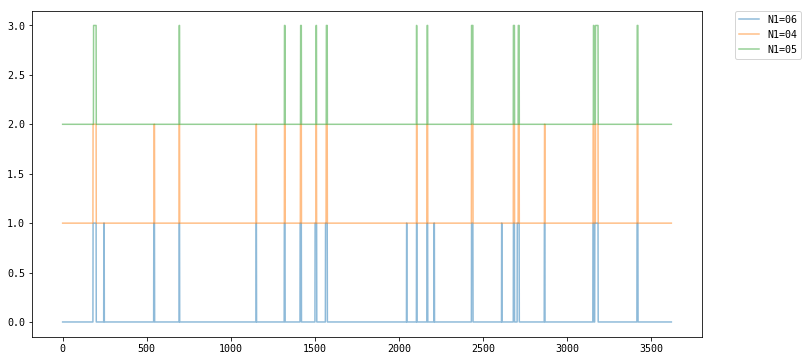

In [4]:
def calc_compdf(oid,tests):

    compdf = pd.DataFrame({'time':[0]*3800,'flux_gap':[0]*3800,'flux_model':[0]*3800,'istop':[0]*3800,'istart':[0]*3800})

    for item in tests:
        location = '{}/test{}/{}_flux.csv'.format(loc,item,oid)
        compdf_flux = pd.read_csv(location,usecols=['flux_gap','time','flux_model'])
        location_flares = '{}/test{}/{}_flares.csv'.format(loc,item,oid)
        compdf_flares = pd.read_csv(location_flares,usecols=['istart','istop'])
        c = compdf_flux.join(compdf_flares)
        compdf = compdf.join(c,rsuffix=item)
    compdf.drop(labels=['time','flux_gap','flux_model','istart','istop'],axis=1,inplace=True)
    compdf.dropna(axis=0, how='all',inplace=True)
    #print(compdf.tail())
    return compdf

def edges_to_bool(df,istart='istart',istop='istop'):
    rangeflare = []
    end=len(df)
    df = df[[istart,istop]]
    df = df.dropna(axis=0, how='all')
    for i,row in df.iterrows():
        rangeflare.append(list(range(int(row[istart]),int(row[istop]))))

    isflare = np.zeros(end)
    rangeflare = [item for sublist in rangeflare for item in sublist]

    np.put(isflare,rangeflare,np.ones_like(rangeflare))
    
    return isflare

compdf = calc_compdf(oid_list[3],tests)

for item in tests:
    compdf['isflare'+item] = edges_to_bool(compdf,istart='istart'+item,istop='istop'+item)

fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)
for i,item in enumerate(tests):
    ax.plot(compdf['isflare'+item]+i,alpha=0.5,label='{}={}'.format(name,item[1:]))
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
fig.show()

## If the exploration above looks sensible, do the same for all light curves in the test sample added together

In [5]:
sample_bool = pd.DataFrame({'data':[0]*3800})
for oid in oid_list:
    OID = str(oid)
    cdf = calc_compdf(oid,tests)
    c=[]
    #print(cdf.head())
    for item in tests:
        c.append(edges_to_bool(cdf,istart='istart'+item,istop='istop'+item))
        #print(np.array(c).shape)
    c = pd.DataFrame(np.array(c).T, columns=['{}{}'.format(OID,tests[0]),'{}{}'.format(OID,tests[1]),'{}{}'.format(OID,tests[2])])
   # print(c.describe())
    #print(type(c1),len(c),type(c))
    sample_bool = sample_bool.join(c)

sample_bool.head()

,data,228682441_06,228682441_04,228682441_05,211410963_06,211410963_04,211410963_05,211411112_06,211411112_04,211411112_05,...,211427574_05,211409099_06,211409099_04,211409099_05,211405388_06,211405388_04,211405388_05,211411477_06,211411477_04,211411477_05
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


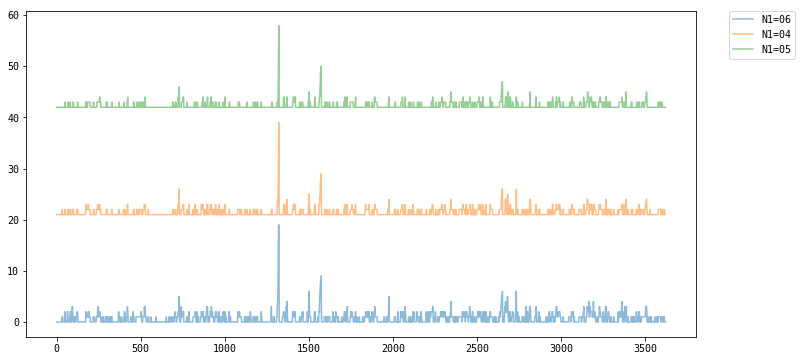

In [6]:
for suffix in tests:
    columns = [item for item in list(sample_bool.columns) if suffix in item]
    #print(columns)
    sample_bool[suffix] = sample_bool[columns].sum(axis=1)
sample_bool.dropna(axis=0,how='all',inplace=True)


f = plt.figure(figsize=(12,6))
ax = f.add_subplot(111)
for i,item in enumerate(tests):
    ax.plot(sample_bool[item]+len(oid_list)*i,alpha=0.5,label='{}={}'.format(name,item[1:]))
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
f.show()